In [867]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [884]:
class myNN():
    def __init__(self, architecture, learning_rate):
        self.architecture = architecture
        self.learning_rate = learning_rate
        self.params = {}
    
    def init_layers(self):
        np.random.seed(99)
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            layer_input_size = layer['input_dim']
            layer_output_size = layer['output_dim']
            self.params['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
            self.params['b' + str(layer_index)] = np.random.randn(layer_output_size, 1) * 0.1
            
    def sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def relu(self, Z):
        return np.maximum(0,Z)
    
    def linear(self, Z):
        return Z
    
    def sigmoid_backward(self, dA, Z):
        sig = self.sigmoid(Z)
        return dA*sig*(1-sig)
    
    def relu_backward(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z<=0] = 0
        return dZ
    
    def linear_backward(self, dA, Z):
        return np.array(Z)
    
    def single_layer_FP(self, A_prev, W_curr, b_curr, activation='relu'):
        #print(W_curr.shape)
        #print(A_prev.shape)
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        #print(Z_curr.shape)
        #print("------")
        if activation == 'relu':
            activation_func = self.relu
        elif activation == 'sigmoid':
            activation_func = self.sigmoid
        elif activation == 'linear':
            activation_func = self.linear
        else:
            raise Exception('Non-supported activation function')
        return activation_func(Z_curr), Z_curr
    
    def forward_propagation(self, x):
        memory = {}
        A_curr = x
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            A_prev = A_curr
            activation_func = layer['activation']
            W_curr = self.params['W'+str(layer_index)]
            b_curr = self.params['b'+str(layer_index)]
            A_curr, Z_curr = self.single_layer_FP(A_prev, W_curr, b_curr, activation_func)
            memory["A"+str(index)] = A_prev
            memory["Z"+str(layer_index)] = Z_curr
        return A_curr, memory
        
    def get_loss_value(self, y, y_predict):
        #print(y.shape)
        #print(y_predict.shape)
        delta = y - y_predict
        loss = np.dot(delta, delta.T)
        return np.squeeze(loss)
    
    def single_layer_BP(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
        m = A_prev.shape[1]
        if activation == 'relu':
            activation_func = self.relu_backward
        elif activation == 'sigmoid':
            activation_func = self.sigmoid_backward
        elif activation == 'linear':
            activation_func = self.linear_backward
        else:
            raise Exception('Non-supported activation function')
        dZ_curr = activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T)/m
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True)/m
        dA_prev = np.dot(W_curr.T, dZ_curr)
        return dA_prev, dW_curr, db_curr
    
    def back_propagation(self, y_predict, y, memory):
        grads_values = {}
        dA_prev = 2*np.sum(y_predict-y)
        for layer_prev_index, layer in reversed(list(enumerate(self.architecture))):
            layer_cur_index = layer_prev_index+1
            activation_func = layer['activation']
            dA_curr = dA_prev
            A_prev = memory['A' + str(layer_prev_index)]
            Z_curr = memory['Z' + str(layer_cur_index)]
            W_curr = self.params['W'+str(layer_cur_index)]
            b_curr = self.params['b'+str(layer_cur_index)]
            dA_prev, dW_curr, db_curr = self.single_layer_BP(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_func)
            grads_values['dW'+str(layer_cur_index)] = dW_curr
            grads_values['db'+str(layer_cur_index)] = db_curr
        return grads_values
    
    def update(self, grads_values):
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            self.params['W'+str(layer_index)] -= self.learning_rate * grads_values['dW'+str(layer_index)]
            self.params['b'+str(layer_index)] -= self.learning_rate * grads_values['db'+str(layer_index)]
    
    def train(self, x, y, epochs, batch_size=16):
        self.init_layers()
        loss_history = []
        for i in range(epochs):
            x, y = shuffle(x, y)
            for i in range(0 ,x.shape[1], batch_size):
                x_min = x[i:i + batch_size]
                y_min = y[i:i + batch_size]
                y_predict, memory = self.forward_propagation(x_min.T)
                loss = self.get_loss_value(np.array([y_min]), y_predict)
                grads_values = self.back_propagation(y_predict, np.array([y_min]), memory)
                self.update(grads_values)
            y_predict, memory = self.forward_propagation(x.T)
            loss = self.get_loss_value(np.array([y]), y_predict)
            print("the lost %lf" % loss)
            loss_history.append(loss)
        return loss_history
    
    def show_parm(self):
        print(self.params)
    
    def predict(self, x):
        y_predict, memory = self.forward_propagation(x)
        return y_predict

In [899]:
# https://www.itread01.com/feffx.html
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
nn_architecture = [
    {"input_dim": 16, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    #{"input_dim": 8, "output_dim": 4, "activation": "sigmoid"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.0001

In [900]:
# Orientation category : 2, 3, 4, 5
# Glazing Area Distribution : 0, 1, 2, 3, 4, 5
data = pd.read_csv('energy_efficiency_data.csv')
heating = data.pop('Heating Load')
cooling = data.pop('Cooling Load')

In [901]:
# for one hot encoding
Orient = pd.get_dummies(data['Orientation'])
Glazing = pd.get_dummies(data['Glazing Area Distribution'])
data = pd.concat([data,pd.get_dummies(data['Orientation'], prefix='Orientation')],axis=1)
data = pd.concat([data,pd.get_dummies(data['Glazing Area Distribution'], prefix='Glazing Area Distribution')],axis=1)
data.drop(['Orientation'],axis=1, inplace=True)
data.drop(['Glazing Area Distribution'],axis=1, inplace=True)

In [902]:
# split data
X_train, X_test, y_train, y_test = train_test_split(data, heating, test_size=0.25, random_state=42)

In [903]:
model = myNN(nn_architecture, learning_rate)
model.train(X_train, np.array(y_train), 1000, batch_size=16)
print("finish")

the lost 349501.504427
the lost 347385.713980
the lost 347421.333064
the lost 345801.248267
the lost 343851.043329
the lost 344409.822859
the lost 345977.932245
the lost 345654.291083
the lost 346332.598968
the lost 344255.875095
the lost 345436.933907
the lost 345433.230392
the lost 346588.757967
the lost 344346.914455
the lost 344925.709385
the lost 345028.262836
the lost 345736.209322
the lost 345463.984704
the lost 344820.402477
the lost 345963.777710
the lost 343869.064783
the lost 343715.804890
the lost 344843.730913
the lost 344459.949633
the lost 345735.776462
the lost 345301.127348
the lost 344545.537274
the lost 344172.910368
the lost 344095.099708
the lost 344328.047519
the lost 345454.382904
the lost 344741.290314
the lost 345429.698489
the lost 345981.998315
the lost 345127.655023
the lost 344207.663112
the lost 344152.992287
the lost 344695.236159
the lost 344911.019375
the lost 345389.276035
the lost 344477.406374
the lost 344053.325999
the lost 343950.388320
the lost 34

the lost 344168.459224
the lost 344118.646278
the lost 344267.069777
the lost 344393.839341
the lost 343988.622857
the lost 343910.444630
the lost 344049.158485
the lost 343818.692932
the lost 343947.499656
the lost 343893.281072
the lost 343630.930267
the lost 343494.263121
the lost 343598.288890
the lost 343581.617847
the lost 343646.179406
the lost 343823.207704
the lost 343851.588322
the lost 343398.653905
the lost 343383.321680
the lost 343646.990748
the lost 344065.772391
the lost 343894.785653
the lost 343461.354677
the lost 343903.567065
the lost 343886.801022
the lost 344061.677752
the lost 344271.391603
the lost 344141.052592
the lost 344308.033126
the lost 344161.858895
the lost 344136.862186
the lost 343904.126919
the lost 344096.507405
the lost 343840.743870
the lost 343598.811554
the lost 343760.775294
the lost 343954.537008
the lost 343603.677678
the lost 343959.003287
the lost 344128.536277
the lost 343557.630760
the lost 343252.613549
the lost 343318.479691
the lost 34

the lost 343310.986943
the lost 343262.476918
the lost 343257.216104
the lost 343344.830791
the lost 343332.791411
the lost 343219.037630
the lost 343168.205116
the lost 343377.268397
the lost 343430.042547
the lost 343415.518766
the lost 343216.649195
the lost 343265.490920
the lost 343177.040281
the lost 343205.950921
the lost 343219.186875
the lost 343215.626583
the lost 343224.820221
the lost 343439.816856
the lost 343472.589207
the lost 343495.639541
the lost 343195.198496
the lost 343315.021898
the lost 343344.070982
the lost 343390.907191
the lost 343513.783141
the lost 343438.272504
the lost 343416.610930
the lost 343402.879002
the lost 343257.985294
the lost 343229.301312
the lost 343382.939163
the lost 343386.767510
the lost 343306.758503
the lost 343276.873058
the lost 343264.828889
the lost 343338.074382
the lost 343377.896907
the lost 343425.839552
the lost 343349.245084
the lost 343329.701496
the lost 343326.061325
the lost 343212.419170
the lost 343181.803469
the lost 34

In [904]:
y_predict = model.predict(X_test.T)
y_predict = np.squeeze(y_predict)

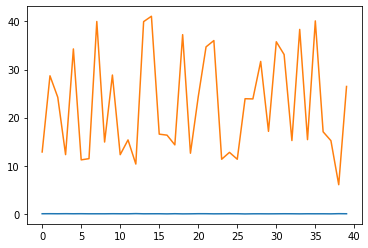

In [905]:
t = range(len(y_predict))
plt.plot(t[:40],y_predict[:40])
plt.plot(t[:40],y_test[:40])
plt.show()

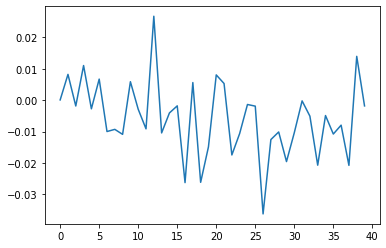

In [906]:
plt.plot(t[:40],y_predict[:40])
plt.show()

(16, 576)